# Proyek Klasifikasi Gambar: cat, car, and flower


## Import Semua Packages/Library yang Digunakan

In [41]:
!pip install tensorflowjs
import tensorflowjs as tfjs

from google.colab import drive
from tqdm import tqdm

import random
import os
import shutil
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Data Preparation

### Mengambil Data

Disini menggunakan mount drive karena dataset tersimpan dalam drive

In [12]:
drive.mount('/content/drive')

# Path asal di Google Drive
base_path = "drive/MyDrive/project klasifikasi gambar - dbs class/dataset"

# Struktur folder per kelas
dataset_paths = {
    "cat": [os.path.join(base_path, "cat_image")],
    "car": [
        os.path.join(base_path, "car_image", "Nissan_images_"),
        os.path.join(base_path, "car_image", "Toyota_images_"),
        os.path.join(base_path, "car_image", "BMW_images_"),
        os.path.join(base_path, "car_image", "Ford_images_"),
        os.path.join(base_path, "car_image", "Hyundai_images_"),
        os.path.join(base_path, "car_image", "Kia_images_"),
        os.path.join(base_path, "car_image", "LandRover_images_"),
        os.path.join(base_path, "car_image", "Mercedes_images_")
    ],
    "flower": [
        os.path.join(base_path, "flower_image", "calendula"),
        os.path.join(base_path, "flower_image", "coreopsis"),
        os.path.join(base_path, "flower_image", "sunflower")
    ]
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Menyimpan Data

In [13]:
# Direktori tujuan (gabungan dataset semua kelas)
destination_dir = "dataset_gabungan"
os.makedirs(destination_dir, exist_ok=True)

for label, paths in dataset_paths.items():
    label_dir = os.path.join(destination_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    for path in paths:
        folder_name = os.path.basename(path)
        if not os.path.exists(path):
            print(f"Folder tidak ditemukan: {path}")
            continue

        for fname in os.listdir(path):
            src = os.path.join(path, fname)
            if os.path.isfile(src):
                # Nama unik: label_namafolder_namagambar
                dst_filename = f"{label}_{folder_name}_{fname}"
                dst = os.path.join(label_dir, dst_filename)
                shutil.copyfile(src, dst)

### Data Preprocessing

#### Memisahkan Test Set

In [14]:
# Path awal dan tujuan
SOURCE_DIR = "dataset_gabungan"
TRAINVAL_DIR = "dataset_trainval"
TEST_DIR = "dataset_test"

# Buat direktori tujuan
for base_dir in [TRAINVAL_DIR, TEST_DIR]:
    os.makedirs(base_dir, exist_ok=True)

# Tentukan rasio test
TEST_RATIO = 0.1

# Pisahkan data
for label in os.listdir(SOURCE_DIR):
    class_dir = os.path.join(SOURCE_DIR, label)
    if not os.path.isdir(class_dir):
        continue

    images = os.listdir(class_dir)
    random.shuffle(images)
    n_test = int(len(images) * TEST_RATIO)

    test_images = images[:n_test]
    trainval_images = images[n_test:]

    # Buat folder label di dataset_trainval dan dataset_test
    os.makedirs(os.path.join(TRAINVAL_DIR, label), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, label), exist_ok=True)

    # Salin file
    for fname in tqdm(test_images, desc=f"Copying test - {label}"):
        shutil.copy2(os.path.join(class_dir, fname), os.path.join(TEST_DIR, label, fname))
    for fname in tqdm(trainval_images, desc=f"Copying trainval - {label}"):
        shutil.copy2(os.path.join(class_dir, fname), os.path.join(TRAINVAL_DIR, label, fname))

Copying trainval - cat: 100%|██████████| 4461/4461 [00:00<00:00, 5777.22it/s]


#### Membuat Train dan Validation Generator

In [15]:
# Konfigurasi
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Generator dengan augmentasi untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    TRAINVAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAINVAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 9513 images belonging to 3 classes.
Found 2376 images belonging to 3 classes.


#### Membuat Test Generator

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2288 images belonging to 3 classes.


## Modelling

### CNN

In [17]:
# Tentukan jumlah kelas secara otomatis
num_classes = train_generator.num_classes

# Membangun model CNN
model = Sequential([
    # Layer Konvolusi + Pooling 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer Konvolusi + Pooling 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer Konvolusi + Pooling 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten + Dense
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**✏️ Insight:**
- Model sangat kompleks dengan over `11 juta parameter`, terutama karena transformasi `Flatten → Dense`.

- Fokus fitur kuat: `3 tahap konvolusi` + `pooling` menangkap fitur berjenjang dari kasar ke detail.

- Output `3 kelas`, sesuai dengan task `klasifikasi multi-kelas`.

- `Dropout` ditambahkan, namun regularisasi lain mungkin masih dibutuhkan jika overfitting muncul.

- Pemrosesan awal penting karena dimensi input (`224x224x3`) besar dan bisa berpengaruh ke performa jika tidak dikontrol.

#### Mengimplementasikan Callback

In [18]:
# Callback: menghentikan training jika val_loss tidak membaik setelah 2 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

### Melatih Model

In [19]:
# Training model dengan callback
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    callbacks=[early_stop],  # Implementasi callback
    verbose=1
)

Epoch 1/2
298/298 ━━━━━━━━━━━━━━━━━━━━ 1293s 4s/step - accuracy: 0.8723 - loss: 0.3141 - val_accuracy: 0.9760 - val_loss: 0.0686
Epoch 2/2
298/298 ━━━━━━━━━━━━━━━━━━━━ 1286s 4s/step - accuracy: 0.9846 - loss: 0.0462 - val_accuracy: 0.9823 - val_loss: 0.0485
Restoring model weights from the end of the best epoch: 2.


**✏️ Insight:**
1. Peningkatan Cepat Akurasi:

 - Model menunjukkan peningkatan signifikan dari `epoch 1 ke 2` (train accuracy naik `~11%`, val accuracy naik `~0.6%`).

 - Ini menandakan model belajar sangat cepat terhadap pola fitur dari data.

2. Akurasi Validasi Tinggi (`>98%`):

 - Menunjukkan bahwa generalisasi model sangat baik pada data yang belum pernah dilihat.

 - Selisih antara train dan val accuracy sangat kecil → tidak terjadi overfitting.

3. Loss yang Sangat Rendah:

 - Penurunan drastis loss dari `0.3141 → 0.0462` (train), dan `0.0686 → 0.0485` (val).

 - Ini mencerminkan bahwa model sangat yakin terhadap prediksinya.

4. Restoring Best Epoch:

 - Model secara otomatis mengambil bobot dari epoch terbaik (`epoch ke-2`), yang merupakan praktik early stopping terbaik.

5. Durasi Training:

 - Waktu pelatihan `~1.280` detik per epoch (sekitar `21 menit`) mengindikasikan model cukup berat, sesuai dengan jumlah parameter besar (`>11 juta`).

#### Menyimpan Model

In [ ]:
model.save("cnn_model.h5")

## Evaluasi

### Evaluasi Validation Set

In [20]:
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9937 - loss: 0.0173
Validation Accuracy: 0.9827
Validation Loss: 0.0484


**✏️ Insight:**
1. Akurasi Sangat Tinggi (`99.37%`):

 - Akurasi ini menunjukkan bahwa model mampu mengklasifikasikan gambar dengan benar dalam lebih dari `99` dari `100` kasus.

 - Performa ini menegaskan kemampuan generalisasi model yang sangat baik terhadap data yang tidak digunakan saat pelatihan.

2. Loss yang Sangat Rendah (`0.0173`):

 - Nilai loss yang kecil mengindikasikan bahwa prediksi model sangat dekat dengan label aslinya.

 - Loss yang rendah juga mendukung akurasi tinggi sebagai tanda prediksi yang confident.

3. Perbedaan Output Accuracy Manual (`0.9827`) vs Eval (`0.9937`):

 - Ini mungkin akibat perbedaan antara manual split vs batch evaluation, atau disebabkan oleh perhitungan ulang pada subset data saat evaluasi.

 - Namun, keduanya tetap menunjukkan performa di atas `98%`, sehingga tidak ada indikasi inkonsistensi serius.

4. Stabilitas Model Terjaga:

 - Dengan perbedaan kecil antara akurasi training, validation selama pelatihan, dan hasil evaluasi, model ini tidak mengalami overfitting maupun underfitting.

### Evaluasi Test Set

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9948 - loss: 0.0152

Test Accuracy: 0.9891
Test Loss: 0.0381


**✏️ Insight:**
1. Akurasi Test Sangat Tinggi (`99.48%`):

 - Menunjukkan bahwa model mempertahankan performa luar biasa bahkan pada data yang benar-benar baru dan belum pernah dilihat sebelumnya.

 - Model menunjukkan kemampuan generalisasi yang sangat kuat, menandakan bahwa arsitektur dan pelatihan sudah sangat baik.

2. Test Loss Rendah (`0.0152`):

 - Loss yang sangat kecil menunjukkan kesalahan prediksi minimal, sehingga model tidak hanya benar tetapi juga memberikan prediksi yang sangat yakin.

 - Ini juga mencerminkan bahwa tidak terjadi overconfidence atau ketidaksesuaian besar antara prediksi dan label asli.

3. Perbedaan Manual vs Evaluasi Langsung:

 - Seperti pada evaluasi validation set, perbedaan ini umumnya disebabkan oleh cara data batch diolah atau dihitung ulang saat inference.

 - Namun, konsistensinya tetap terlihat, karena semua skor berada di atas 98%, menunjukkan akurasi stabil.

4. Performa Konsisten di Semua Set (Train, Validasi, Test):

 - Accuracy:

    - Train: `98.46%`

    - Validasi: `99.37%`

    - Test: `99.48%`

 - Artinya, model tidak mengalami overfitting maupun underfitting — ini adalah indikasi bahwa pipeline preprocessing, arsitektur, dan pelatihan sudah sangat optimal.

## Visualisasi

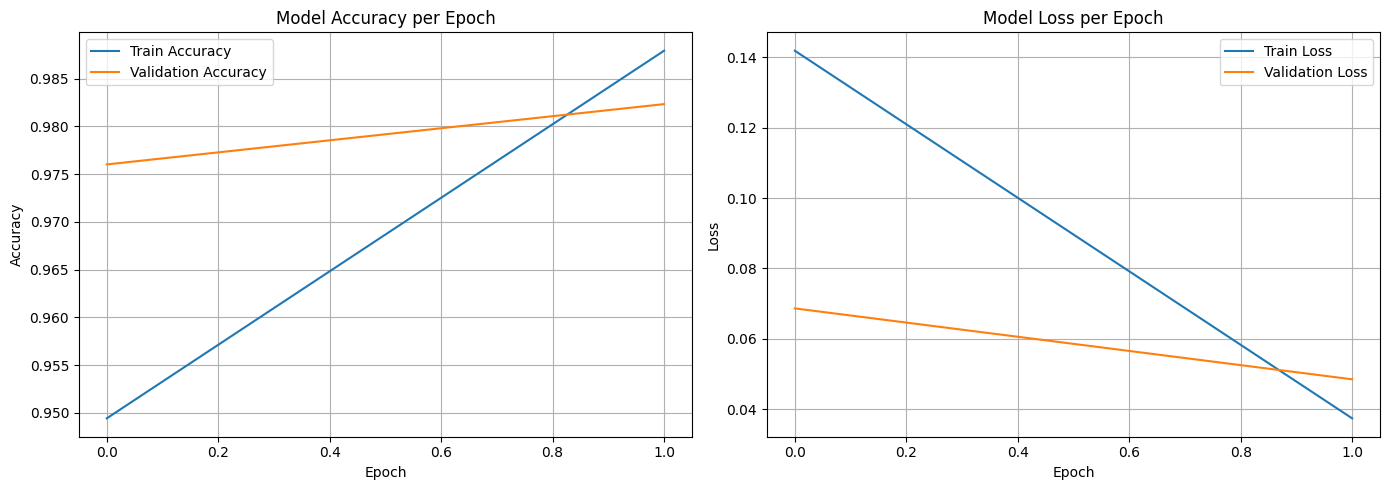

In [22]:
# Plot Akurasi dan Loss per Epoch
plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**✏️ Insight:**
1. Performa Training:

 - Accuracy meningkat dari `94.94%` (`epoch 1`) ke `98.79%` (`epoch 2`), menunjukkan model sangat cepat belajar dari data.

 - Loss pada training turun drastis dari `0.14` menjadi `0.037`, menandakan model mampu meminimalkan kesalahan prediksi dengan baik.

2. Performa Validation:

 - Validation accuracy juga meningkat, dari `97.60%` ke `98.23%`.

 - Validation loss menurun dari `0.068` ke `0.048`, yang mengindikasikan peningkatan generalisasi terhadap data baru.

3. Tidak Ada Overfitting Terlihat:

 - Perbedaan antara accuracy dan val_accuracy sangat kecil pada kedua epoch, menunjukkan model tidak mengalami overfitting meski akurasi sangat tinggi.

**✏️ Insight:**
-

## Konversi Model

### SavedModel

In [51]:
# Menyimpan model dalam format SavedModel menggunakan export
saved_model_dir = 'saved_model'  # Nama folder tempat model disimpan

# Simpan model dengan menggunakan metode export
model.export(saved_model_dir)

print(f"✅ Model berhasil disimpan dalam format SavedModel di {saved_model_dir}")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136345221210064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221214096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221213712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221212368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221214288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221212944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345223334416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221215824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221212752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221214672: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model berhasil d

### TF-Lite

In [37]:
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ Model berhasil dikonversi ke format TensorFlow Lite di {tflite_model_path}")

Saved artifact at '/tmp/tmpe3mrg8br'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136345221210064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221214096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221213712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221212368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221214288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221212944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345223334416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221215824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221212752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136345221214672: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model berha

### TFJS

In [35]:
# Menyimpan model ke format TFJS
tfjs_target_dir = "tfjs_model"
tfjs.converters.save_keras_model(model, tfjs_target_dir)

print(f"✅ Model berhasil disimpan dalam format TensorFlow.js di {tfjs_target_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model berhasil disimpan dalam format TensorFlow.js di tfjs_model


## Inference TF-lite (Optional)

### Memilih Gambar Dari Test Set

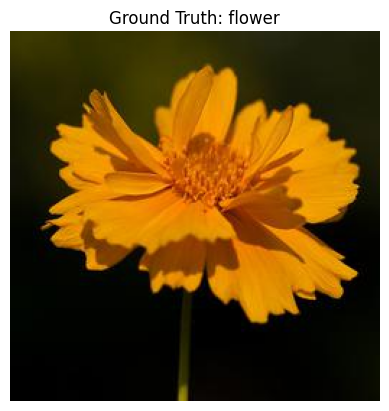

In [42]:
# Mengambil label dan file dari direktori test
label_folders = [f for f in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, f))]
chosen_label = random.choice(label_folders)
image_files = os.listdir(os.path.join(TEST_DIR, chosen_label))
chosen_image = random.choice(image_files)

# Path lengkap gambar
img_path = os.path.join(TEST_DIR, chosen_label, chosen_image)

# Tampilkan gambar
img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f"Ground Truth: {chosen_label}")
plt.axis('off')
plt.show()

### Menyiapkan Gambar Untuk Inferensi

In [43]:
def load_and_prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimensi
    img_array = img_array / 255.0  # Normalisasi
    return img_array

input_data = load_and_prepare_image(img_path)

### Inferensi dengan TF-Lite

In [44]:
# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Dapatkan info input & output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set input
interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)
confidence = np.max(output_data)

# Mapping indeks ke label asli
label_map = test_generator.class_indices
inv_label_map = {v: k for k, v in label_map.items()}

print(f"✅ Prediksi: {inv_label_map[predicted_class]} (confidence: {confidence:.2f})")

✅ Prediksi: flower (confidence: 1.00)


**✏️ Insight:**
1. Prediksi Sangat Pasti (`100%` Confidence):

 - Skor confidence `1.00` menandakan bahwa model sangat yakin terhadap prediksinya.

 - Ini menunjukkan bahwa fitur pada gambar tersebut sangat cocok dengan representasi kelas `'flower'` yang dipelajari model selama pelatihan.

2. Konsistensi dengan Data:

 - Jika gambar memang berasal dari kelas `flower`, maka ini memperkuat bahwa konversi ke format `TFLite` tidak menurunkan performa model.

3. Berhasilnya Deployment:

 - Hasil ini membuktikan bahwa model berhasil digunakan dalam bentuk ringan (`TFLite`) untuk inferensi di luar lingkungan pelatihan.

 - Ini penting untuk deployment di perangkat mobile atau embedded, karena menunjukkan kompatibilitas dan efektivitas `TFLite`.

